In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import datetime
import torch
import os
from tqdm import tqdm
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
#!pip install tqdm
import tqdm
import os
import copy
import pandas as pd
import PIL 
import time as t

[25, 50, 75, 100, 125, 150, 175, 200, 225]

In [10]:
""" Evaluate ROC
Returns:
    auc, eer: Area under the curve, Equal Error Rate
"""
from __future__ import print_function

import os
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## MODEL DEFINITION

In [11]:
# Refer to https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [12]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [13]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [14]:
class Model(nn.Module):
    """ ITAE model """

    def __init__(self, n_channels=3, bilinear=True):
        super(Model, self).__init__()
        # Encoder
        self.in_conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        
        # Decoder
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64)
        
        # seems that the structure in paper does not contain 'tanh'
        self.out_conv = nn.Conv2d(64, n_channels, kernel_size=3, stride=1, padding=1, bias=False)# Unet use 1*1conv to be out_conv

    def forward(self, x):
        x0_2 = self.in_conv(x)
        x1_3 = self.down1(x0_2)
        x2_3 = self.down2(x1_3)
        x3_3 = self.down3(x2_3)
        x4_3 = self.down4(x3_3)
        x = self.up1(x4_3, x3_3)
        x = self.up2(x, x2_3)
        x = self.up3(x, x1_3)
        x = self.up4(x, x0_2)
        out = torch.tanh(self.out_conv(x))
        return out

## TRAINING LOOP DEFINITION 

In [16]:
def train_epoch(epoch_i, model, train_loader, criterion, optimizer, running_loss, train_scheduler, model_name = 'default_AE'): #cfg, log, train_scheduler):

    batch_time = AverageMeter()  # measure the batch time
    data_time = AverageMeter()  # measure the average time on data
    losses = AverageMeter()    # measure the average loss

    model.train()          # set the model into the training mode

    end_time = time.time()
    
    # iterate over the batches in the epoch
    for input_img, label in tqdm(train_loader):
        model.zero_grad() # restart gradients
        
        data_time.update(time.time() - end_time)
        curr_time = datetime.datetime.now()
        curr_time = datetime.datetime.strftime(curr_time, '%Y-%m-%d %H:%M:%S')
        
        input_img = input_img.to(device) 
        
        restore_image = model(input_img) # run the image through the autoencoder
        
        loss = criterion(restore_image, input_img) # debug the dtype of label image, need 'long'?
        
        loss.backward()  # backpropagate loss
        optimizer.step()  # optimizer
        
        running_loss += loss.item() * input_img.size(0)
        losses.update(loss.item(), input_img.size(0)) # update the average loss
        batch_time.update(time.time() - end_time)   # update the average batch time
        end_time = time.time() 
        
    print('{0}\t' 'Epoch: {2}' 'Loss {loss.val:.4f} ({loss.avg:.4f})\t''lr {1}'.format(curr_time, optimizer.param_groups[0]['lr'], epoch_i, loss=losses))
    
    if epoch_i%5 == 0:
        torch.save({'state_dict':model.state_dict()}, '/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/AutoEncoders/' + model_name)
    
    train_scheduler.step()  # update the scheduler
    return running_loss

In [8]:
def test_epoch(model, train4val_loader, test_loader, criterion, cfg, log, i=1):

    model.eval()
    t = cfg.transformations
    with torch.no_grad():
        print('evaluate on the train dataset for normal samples L1 error-------')
        nrm_err = torch.zeros(size=(len(train4val_loader.dataset), t), dtype=torch.float32).cuda()
        for i_batch, (tfs_images, org_image, label) in enumerate(tqdm(train4val_loader)):
            b, t, c, h, w = tfs_images.size()#c=1
            tfs_images = tfs_images.view(b*t, c, h, w).cuda()
            org_image = org_image.cuda()# b c h w
            restore_images = model(tfs_images)
            restore_images = restore_images.view(b, t, cfg.nc, h, w)
            for j in range(t):
                err = criterion(restore_images[:, j, :], org_image)# debug the shape of err
                nrm_err[i_batch*cfg.batchsize: i_batch*cfg.batchsize+err.size(0), j] = err.reshape(err.size(0))
        # print((nrm_err.size()))
        nrm_err = torch.mean(nrm_err, dim=0)# shape: t

        print('evaluate on the test dataset for normalized L1 error-------')
        abn_err = torch.zeros(size=(len(test_loader.dataset), t), dtype=torch.float32).cuda()
        abn_tgt = torch.zeros(size=(len(test_loader.dataset),), dtype=torch.long).cuda()
        for i_batch, (tfs_images, org_image, label) in enumerate(tqdm(test_loader)):
            b, t, c, h, w = tfs_images.size()
            tfs_images = tfs_images.view(b*t, c, h, w).cuda()
            org_image = org_image.cuda()# b c h w
            restore_images = model(tfs_images)
            restore_images = restore_images.view(b, t, cfg.nc, h, w)
            abn_tgt[i_batch * cfg.batchsize: i_batch * cfg.batchsize + b] = label.reshape(b)
            for j in range(t):
                err = criterion(restore_images[:, j, :], org_image) / nrm_err[j]
                abn_err[i_batch * cfg.batchsize: i_batch * cfg.batchsize + err.size(0), j] = err.reshape(err.size(0))
        abn_err = torch.mean(abn_err, dim=1)# shape: len(test_loader.dataset)

        auroc = evaluate(abn_tgt, abn_err, metric='roc')

        print('the test dataset AUROC is {}%'.format(auroc * 100))

        if auroc > cfg.best_auroc:
            save_file_path = os.path.join(cfg.work_dir, 'model')
            mmcv.mkdir_or_exist(save_file_path)
            states = {
                'epoch': i,
                'state_dict': model.state_dict()
            }
            torch.save(states, os.path.join(save_file_path, 'best_model.pth'))
            cfg.best_auroc = auroc

## Loading the Data

In [17]:
def get_image_transforms():
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.0857], [0.1818]),
        ])
    return transform


In [19]:
bs = 32

model = Model(n_channels= 1, bilinear= True)
model = model.to(device)

criterion = torch.nn.MSELoss()#squared l2 loss
optimizer = optim.SGD(model.parameters(), lr= 0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = datasets.ImageFolder('/home/ryznerf/Computer_Vision/pytorch_data_input/train', get_image_transforms())
train_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, num_workers=4, shuffle = True)

dataset_val = datasets.ImageFolder('/home/ryznerf/Computer_Vision/pytorch_data_input/test', get_image_transforms())
train_val = torch.utils.data.DataLoader(dataset_val, batch_size=bs, num_workers=4, shuffle = True)


iter_per_epoch = len(train_loader)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.1 * i * 250) for i in range(1, 10)], gamma=0.5)

# for i in range(0, 1):
#     train_epoch(i, model, train_loader, criterion, optimizer, cfg, log, train_scheduler)
#     test_epoch(model, train4val_loader, test_loader, L1_measure, cfg, log, i)

In [20]:
#train_epoch(epoch_i, model, train_loader, criterion, optimizer, running_loss, train_scheduler, model_name = 'default_AE')

from tqdm import tqdm
rl = 0

for i in range(0, 250):
    rl = train_epoch(i, model, train_loader, criterion, optimizer, rl, train_scheduler, model_name = 'default_AE_mix3')
#    test_epoch(model, train4val_loader, test_loader, L1_measure, cfg, log, i)

  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:24:01	0Loss 0.2493 (0.3359)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:25:05	1Loss 0.3747 (0.3187)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:26:09	2Loss 0.4239 (0.3177)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:27:14	3Loss 0.2746 (0.3176)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:28:18	4Loss 0.1905 (0.3174)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:29:22	5Loss 0.3992 (0.3170)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:30:27	6Loss 0.2856 (0.3169)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:31:31	7Loss 0.2388 (0.3167)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:32:35	8Loss 0.3536 (0.3167)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:33:39	9Loss 0.4253 (0.3165)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:34:43	10Loss 0.3802 (0.3166)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:35:47	11Loss 0.2297 (0.3166)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:36:51	12Loss 0.2803 (0.3163)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:37:54	13Loss 0.2925 (0.3164)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:38:58	14Loss 0.4252 (0.3162)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:40:02	15Loss 0.3395 (0.3162)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:41:06	16Loss 0.3287 (0.3161)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:42:09	17Loss 0.2198 (0.3162)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:43:13	18Loss 0.4214 (0.3161)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:44:17	19Loss 0.2854 (0.3161)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:45:22	20Loss 0.3332 (0.3161)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:46:26	21Loss 0.3184 (0.3159)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:47:30	22Loss 0.4006 (0.3160)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:48:34	23Loss 0.2583 (0.3159)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:49:39	24Loss 0.4162 (0.3160)	lr 0.1


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:50:43	25Loss 0.2122 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:51:47	26Loss 0.3194 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:52:51	27Loss 0.4472 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:53:55	28Loss 0.2295 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:54:59	29Loss 0.4040 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:56:03	30Loss 0.2776 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:57:06	31Loss 0.4266 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:58:10	32Loss 0.3442 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 21:59:14	33Loss 0.2352 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:00:18	34Loss 0.3131 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:01:22	35Loss 0.2796 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:02:26	36Loss 0.3054 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:03:29	37Loss 0.3647 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:04:33	38Loss 0.2681 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:05:37	39Loss 0.3141 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:06:41	40Loss 0.3128 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:07:45	41Loss 0.2866 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:08:49	42Loss 0.3567 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:09:52	43Loss 0.2901 (0.3158)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:10:56	44Loss 0.3981 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:12:00	45Loss 0.3100 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:13:04	46Loss 0.3247 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:14:08	47Loss 0.3345 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:15:12	48Loss 0.3128 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:16:16	49Loss 0.4088 (0.3157)	lr 0.05


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:17:19	50Loss 0.3543 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:18:23	51Loss 0.3978 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:19:27	52Loss 0.3790 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:20:31	53Loss 0.2423 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:21:35	54Loss 0.3308 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:22:39	55Loss 0.2235 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:23:42	56Loss 0.3179 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:24:46	57Loss 0.1814 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:25:50	58Loss 0.3104 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:26:54	59Loss 0.2951 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:27:58	60Loss 0.4053 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:29:02	61Loss 0.2617 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:30:05	62Loss 0.3090 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:31:09	63Loss 0.2257 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:32:13	64Loss 0.3497 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:33:17	65Loss 0.2780 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:34:21	66Loss 0.2338 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:35:25	67Loss 0.2365 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:36:29	68Loss 0.4058 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:37:33	69Loss 0.2890 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:38:37	70Loss 0.3377 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:39:40	71Loss 0.2161 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:40:44	72Loss 0.3094 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:41:48	73Loss 0.3740 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:42:52	74Loss 0.1530 (0.3157)	lr 0.025


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:43:56	75Loss 0.2827 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:45:00	76Loss 0.3417 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:47:08	78Loss 0.2830 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:48:13	79Loss 0.3192 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:49:17	80Loss 0.4840 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:50:21	81Loss 0.2509 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:51:25	82Loss 0.2425 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:52:29	83Loss 0.2852 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:53:34	84Loss 0.2737 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:54:38	85Loss 0.2657 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:55:42	86Loss 0.3832 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:56:46	87Loss 0.3096 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:57:51	88Loss 0.3315 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:58:55	89Loss 0.4092 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 22:59:59	90Loss 0.2596 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:01:03	91Loss 0.3378 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:02:08	92Loss 0.2479 (0.3157)	lr 0.0125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:03:12	93Loss 0.2408 (0.3157)	lr 0.0125


 58%|█████▊    | 108/187 [00:37<00:27,  2.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:25:09	113Loss 0.3616 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:26:15	114Loss 0.2939 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:27:20	115Loss 0.1980 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:28:26	116Loss 0.2607 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:29:39	117Loss 0.3343 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:30:52	118Loss 0.4531 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:31:56	119Loss 0.3256 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:33:01	120Loss 0.3428 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:34:05	121Loss 0.2694 (0.3156)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:35:10	122Loss 0.2772 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:36:14	123Loss 0.3875 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:37:18	124Loss 0.3369 (0.3157)	lr 0.00625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:38:22	125Loss 0.3147 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:39:26	126Loss 0.3270 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:40:32	127Loss 0.3289 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:41:44	128Loss 0.3351 (0.3157)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:42:55	129Loss 0.3488 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:43:59	130Loss 0.2827 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:45:03	131Loss 0.2739 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:46:07	132Loss 0.3594 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:47:11	133Loss 0.2104 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:48:22	134Loss 0.2276 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:49:34	135Loss 0.4150 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:50:46	136Loss 0.2455 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:51:58	137Loss 0.3741 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:53:10	138Loss 0.4773 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:54:14	139Loss 0.2367 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:55:18	140Loss 0.3031 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:56:25	141Loss 0.3047 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:57:29	142Loss 0.3418 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:58:33	143Loss 0.2998 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-06 23:59:37	144Loss 0.3321 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:00:40	145Loss 0.3181 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:01:44	146Loss 0.2306 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:02:48	147Loss 0.2246 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:03:52	148Loss 0.2733 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:04:56	149Loss 0.2618 (0.3156)	lr 0.003125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:06:01	150Loss 0.4494 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:07:13	151Loss 0.2288 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:08:25	152Loss 0.2903 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:09:37	153Loss 0.3441 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:10:49	154Loss 0.3015 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:11:59	155Loss 0.3560 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:13:03	156Loss 0.4241 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:14:06	157Loss 0.4716 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:15:10	158Loss 0.3263 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:16:14	159Loss 0.3126 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:17:18	160Loss 0.3840 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:18:22	161Loss 0.3398 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:19:26	162Loss 0.3349 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:20:30	163Loss 0.3141 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:21:33	164Loss 0.2558 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:22:37	165Loss 0.3628 (0.3157)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:23:41	166Loss 0.3549 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:24:45	167Loss 0.2920 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:25:48	168Loss 0.4551 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:26:52	169Loss 0.4263 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:27:56	170Loss 0.2762 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:29:00	171Loss 0.2569 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:30:04	172Loss 0.3441 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:31:08	173Loss 0.2333 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:32:13	174Loss 0.3070 (0.3156)	lr 0.0015625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:33:17	175Loss 0.4118 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:34:21	176Loss 0.3573 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:35:26	177Loss 0.3098 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:36:30	178Loss 0.4244 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:37:34	179Loss 0.2282 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:38:38	180Loss 0.2625 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:39:42	181Loss 0.3354 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:40:46	182Loss 0.1469 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:41:50	183Loss 0.2476 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:42:55	184Loss 0.2075 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:43:59	185Loss 0.3451 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:45:03	186Loss 0.2081 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:46:08	187Loss 0.3899 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:47:12	188Loss 0.2596 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:48:16	189Loss 0.3413 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:49:20	190Loss 0.1873 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:50:25	191Loss 0.3783 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:51:29	192Loss 0.4060 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:52:33	193Loss 0.3228 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:53:38	194Loss 0.3880 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:54:42	195Loss 0.4463 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:55:46	196Loss 0.3880 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:56:51	197Loss 0.4412 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:57:55	198Loss 0.4067 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 00:58:59	199Loss 0.1996 (0.3156)	lr 0.00078125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:00:04	200Loss 0.3666 (0.3157)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:01:08	201Loss 0.4303 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:02:12	202Loss 0.3381 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:03:16	203Loss 0.3071 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:04:20	204Loss 0.3526 (0.3157)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:05:24	205Loss 0.3141 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:06:29	206Loss 0.3749 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:07:33	207Loss 0.2490 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:08:37	208Loss 0.2298 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:09:41	209Loss 0.2799 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:10:46	210Loss 0.4271 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:11:50	211Loss 0.2563 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:12:54	212Loss 0.3017 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:13:59	213Loss 0.3131 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:15:03	214Loss 0.2706 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:16:08	215Loss 0.2515 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:17:12	216Loss 0.3328 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:18:16	217Loss 0.3659 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:19:20	218Loss 0.2757 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:20:24	219Loss 0.2793 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:21:28	220Loss 0.2852 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:22:32	221Loss 0.3072 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:23:36	222Loss 0.3452 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:24:41	223Loss 0.3154 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:25:45	224Loss 0.3551 (0.3156)	lr 0.000390625


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:26:49	225Loss 0.2246 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:27:53	226Loss 0.2822 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:28:57	227Loss 0.2558 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:30:02	228Loss 0.2382 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:31:06	229Loss 0.3119 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:32:11	230Loss 0.3207 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:33:15	231Loss 0.2333 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:34:19	232Loss 0.2427 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:35:24	233Loss 0.3407 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:36:28	234Loss 0.3243 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:37:32	235Loss 0.3121 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:38:37	236Loss 0.3234 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:39:41	237Loss 0.3609 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:40:45	238Loss 0.2552 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:41:49	239Loss 0.4391 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:42:53	240Loss 0.3818 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:43:58	241Loss 0.4371 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:45:02	242Loss 0.3977 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:46:06	243Loss 0.3896 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:47:11	244Loss 0.3075 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:48:15	245Loss 0.3496 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:49:19	246Loss 0.1791 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:50:24	247Loss 0.3274 (0.3156)	lr 0.0001953125


  0%|          | 0/187 [00:00<?, ?it/s]

2022-05-07 01:51:28	248Loss 0.2390 (0.3156)	lr 0.0001953125


100%|██████████| 187/187 [01:04<00:00,  3.18it/s]

2022-05-07 01:52:32	249Loss 0.2645 (0.3156)	lr 0.0001953125


In [ ]:
out = next(iter(train_val))
#out.shape

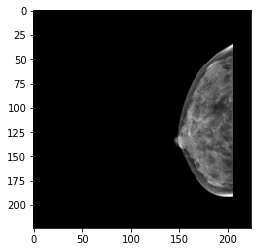

In [27]:
plt.imshow(out[0][20][0].detach().cpu().numpy(), cmap ='gray')
plt.show()

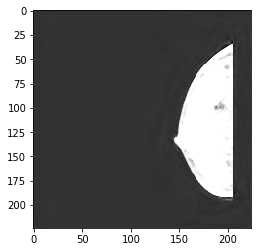

In [28]:
model = model.to(device)
res = model(out[0].to(device))
res.shape
plt.imshow(res[20][0].detach().cpu().numpy(), cmap ='gray')
#plt.show()

In [26]:
model_name = 'default_AE'
torch.save({'state_dict':model.state_dict()}, '/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/AutoEncoders/' + model_name)

In [22]:
y = torch.load('/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/AutoEncoders/' + model_name)

In [11]:
model_name = 'default_AE'
model = Model(n_channels= 1, bilinear= True)
checkpoint = torch.load('/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/AutoEncoders/' + model_name)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [11]:
rl

0